<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/Udacity%3A%20Intro%20to%20TensorFlow%20for%20DL/UTFD_L7C2_Saving_and_Loading_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [4]:
!pip install -q -U tensorflow
!pip install -q -U tensorflow_hub # For Transfer Learning
!pip install -q -U tensorflow_datasets

In [5]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

## Part 1: Load Datasets

- Cats vs Dogs

In [7]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


This images in the Dogs vs. Cats dataset are not all the same size. So we need to resize them to the resolution expected by MobileNet (224, 224).

In [8]:
# define
BATCH_SIZE = 32
IMAGE_RES = 224

num_examples = info.splits['train'].num_examples

In [9]:
def format_image(image, label):
  # 'hub' image modules expect their data mormalized to the [0, 1]
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

In [11]:
train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

## Part 2: Transfer Learning with TensorFlow Hub

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [13]:
feature_extractor.trainable = False

### Attach a Classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and a new classification layer.

In [16]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2) # Classification Output
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [20]:
# define
EPOCHS = 3

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 426s 720ms/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 2/3
582/582 [==============================] - 408s 702ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0301 - val_accuracy: 0.9903
Epoch 3/3
582/582 [==============================] - 405s 696ms/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0305 - val_accuracy: 0.9899


### Check the predictions

In [22]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run an image batch through the model and convert the indices to class names.

In [23]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = class_names[predicted_ids]

In [24]:
predicted_class_names

array(['cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog',
       'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [27]:
print('True Lables: ', label_batch)
print('Predicted Labels: ', predicted_ids)

True Lables:  [0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0]
Predicted Labels:  [0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0]


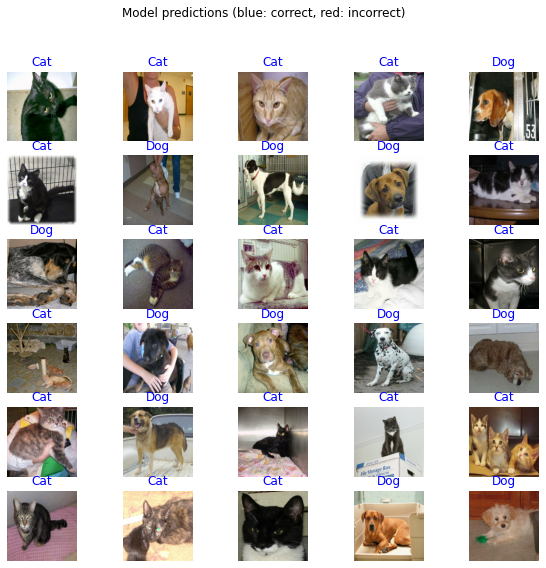

In [28]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## Part 3: Save as Keras `.h5` model

We can save our trained model as an HDF% file, which is the format used by Keras.

It will have the extension `.h5` and it's name will correspond to the current time stamp.

In [30]:
t = time.time()

export_path_keras = f'./{int(t)}.h5'

In [31]:
export_path_keras

'./1633420269.h5'

In [32]:
model.save(export_path_keras)

In [33]:
!ls

1633420269.h5  sample_data


We can recreate the same model later from this file, even if we no longer have access to the code that created the model.

This file includes:
- The model's architecture
- The model's weight which were learned during training
- The model's training config
- The optimzer and it's state (It enables to restart training where we left off)

## PArt 4: Load the Keras `.h5` Model

We will now load the model we just saved as `reloaded`.

We will need to provide the file path and the `custom_object` parameter. This parameter tells Keras how to load the `hub.KerasLayer` from the `feature_extractor` we used for transfer learning.

In [34]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

In [35]:
reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Check the reloaded model wheter it gives same result with previous model.

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

If same, the difference in output should be zero.

In [37]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

### Keep Training

Besides making predictions, we can also take our `reloaded` model and keep training it.

Just train it as usual!

In [39]:
# define
EPOCHS = 3

history = reloaded.fit(train_batches,
                       epochs = EPOCHS,
                       validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 450s 769ms/step - loss: 0.0220 - accuracy: 0.9922 - val_loss: 0.0396 - val_accuracy: 0.9856
Epoch 2/3
582/582 [==============================] - 475s 817ms/step - loss: 0.0193 - accuracy: 0.9932 - val_loss: 0.0317 - val_accuracy: 0.9901
Epoch 3/3
582/582 [==============================] - 481s 827ms/step - loss: 0.0172 - accuracy: 0.9938 - val_loss: 0.0337 - val_accuracy: 0.9901


## Part 5: Export as SavedModel

We can export a whole model to TensorFlow SavedModel format using `tf.saved_model.save()`. This functions will create a folder where you will find an `assets` folder, a variables folder, and the `saved_model.pb` file

SavedModel is a standalone serialization format for TensorFlow objects, supported by TensorFlow serving as well as TensorFlow Implementations other than Python.

A SavedModel contains a complete TensorFlow program, including weights and computation.

It does not require the original model building code to run, which make it useful for sharing or deploying.

The SavedModel files that were created contain:

- A TensorFlow checkpoint containing the model weights.

- A SavedModel proto containing the underlying TensorFlow graph. Seperate graphs are saved for prediction (serving), traing, and evaluation. (If the model wasn't compiled before, then only the inference graph gets exported)

- The model's archtecture config, if available.

In [40]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1633422838
INFO:tensorflow:Assets written to: ./1633422838/assets


INFO:tensorflow:Assets written to: ./1633422838/assets


In [41]:
!ls {export_path_sm}

assets	saved_model.pb	variables


## Part 6: Load SavedModel

Use the `tf.saved_model.load()` ti load our SavedModels.

The object returned by `tf.saved_model.load` is 100% independent of the code that created it.

In [42]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [43]:
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

Check the result

In [45]:
(abs(result_batch - reloaded_sm_result_batch)).max()

0.0

## Part 7: Loading the SavedModel as a Keras Model

The object returned by `tf.saved_model.load` is not a Keras object, so it doesn't have `.fit`, `.predict`, or `.summary`, etc.

Therefore, we can't simply take our `reloaded_sm` model and keep training it by running `.fit`.

To be able to get back a full keras model from the TensorFlow SavedModel format, we must use the `tf.keras.models.load_model`.

In [50]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.keras.models.save_model(model, export_path_sm)

./1633423413
INFO:tensorflow:Assets written to: ./1633423413/assets


INFO:tensorflow:Assets written to: ./1633423413/assets


In [51]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

In [53]:
result_batch = model.predict(image_batch)
reloaded_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

Check the result.

In [54]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

## Part 8: Download Model

Download the SavedModel to local disk by a zip file.

Use `-r` (recurcise) option to zip all subfolder.

In [55]:
!zip -r model.zip {export_path_sm}

  adding: 1633423413/ (stored 0%)
  adding: 1633423413/assets/ (stored 0%)
  adding: 1633423413/saved_model.pb (deflated 92%)
  adding: 1633423413/keras_metadata.pb (deflated 80%)
  adding: 1633423413/variables/ (stored 0%)
  adding: 1633423413/variables/variables.index (deflated 78%)
  adding: 1633423413/variables/variables.data-00000-of-00001 (deflated 8%)


In [56]:
!ls

1633420269.h5  1633422838  1633423357  1633423413  model.zip  sample_data


Download file to local disk from working directory.

In [57]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The `files.download` command will  search for files in your current working directory. If the file you want to download is in a directory other than the current working directory, you have to include the path to the directory where the file is located.